In [10]:
!pip install jupyter-black
%load_ext jupyter_black

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black


In [11]:
from google.colab import drive
import sys
import os

drive.mount("/content/drive")
PATH = "/content/drive/MyDrive/HW_1"
# sys.path.append(PATH)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Импорт библиотек и стилей

In [12]:
!cp "{PATH}/styles.py" .

In [13]:
import numpy as np
import os
from styles import styles, styles_count
from PIL import Image

import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

In [14]:
!pip install -U gdown
import gdown
import zipfile
import os
import shutil

# Генератор стилей

In [15]:
import numpy as np
import os
from styles import styles, styles_count
from PIL import Image
import math

In [16]:
class BayesianStyleGenerator:
    """
    Генератор стилей с использованием байесовской предиктивной вероятности и MLE-подхода.
    Для каждой категории "категория→варианты" считает апостериорное распределение:
      P(option_i) = (count_i + alpha) / (N + alpha * K)
    при count_i — наблюдаемая частота, N — сумма count, K — число опций.
    """

    def __init__(self, styles_dict, counts_dict, alpha: float = 1.0):
        self.options = styles_dict
        self.alpha = alpha
        # Построим предиктивное распределение для каждой категории
        self.post_predictive = {}
        for category, choices in styles_dict.items():
            cnt = np.array(counts_dict[category], dtype=float)
            K = len(choices)
            total = cnt.sum() + alpha * K
            # predictive P = (count + alpha) / total
            self.post_predictive[category] = (cnt + alpha) / total

    def sample(self):
        """
        Возвращает:
          - sampled_style: dict категория→выбранный вариант
          - prob: полная вероятность генерации этого стиля
        """
        sampled_style = {}
        total_prob = 1.0
        for category, choices in self.options.items():
            p = self.post_predictive[category]
            idx = np.random.choice(len(choices), p=p)
            sampled_style[category] = choices[idx]
            total_prob *= p[idx]
        return sampled_style, total_prob

In [17]:
gen = BayesianStyleGenerator(styles, styles_count, alpha=1.0)
for i in range(5):
    style, prob = gen.sample()
    print(f"{i+1}: {style}, P = {prob:.3e}")

1: {'прическа': 'нет волос', 'цвет волос': 'блонд', 'аксесуар': 'нет очков', 'одежда': 'футболка с V-вырезом', 'цвет одежды': 'зеленый'}, P = 7.990e-05
2: {'прическа': 'длинные прямые', 'цвет волос': 'черный', 'аксесуар': 'круглые очки', 'одежда': 'комбинезон', 'цвет одежды': 'зеленый'}, P = 1.425e-03
3: {'прическа': 'короткая прямые', 'цвет волос': 'серебристо серый', 'аксесуар': 'солнцезащитные очки', 'одежда': 'комбинезон', 'цвет одежды': 'оранжевый'}, P = 1.355e-03
4: {'прическа': 'длинные прямые', 'цвет волос': 'пастельный розовый', 'аксесуар': 'нет очков', 'одежда': 'футболка с круглым вырезом', 'цвет одежды': 'розовый'}, P = 3.913e-04
5: {'прическа': 'короткая прямые', 'цвет волос': 'черный', 'аксесуар': 'солнцезащитные очки', 'одежда': 'комбинезон', 'цвет одежды': 'белый'}, P = 4.337e-04


# Генератор пикселей на основе изображений

In [18]:
class PixelGenerator:
    """
    Анализ всех изображений в папке avatars и построение для каждого
    пикселя (x, y) и канала (R, G, B) дискретного распределения
    интенсивностей (0..255) методом MLE. После генерирация новых аватаров.
    Вывод: изображение и его логарифм вероятности.
    """

    def __init__(self, avatars_folder):
        os.makedirs(avatars_folder, exist_ok=True)
        files = [
            os.path.join(avatars_folder, f)
            for f in os.listdir(avatars_folder)
            if f.lower().endswith((".png", ".jpg", ".jpeg"))
        ]
        images = [np.array(Image.open(fp).convert("RGB")) for fp in files]
        if not images:
            raise ValueError(f"No images found in {avatars_folder}")
        self.height, self.width, self.channels = images[0].shape
        n_images = len(images)

        # Собираем частоты: shape (H, W, C, 256)
        counts = np.zeros((self.height, self.width, self.channels, 256), dtype=np.int64)
        for img in images:
            for v in range(256):
                counts[:, :, :, v] += img == v

        # Вычисляем MLE-вероятности и логарифмы вероятностей
        self.probs = counts.astype(float) / n_images
        self.log_probs = np.log(self.probs, where=self.probs > 0)

    def sample(self):
        # Генерируем новое изображение по распределениям
        new_arr = np.zeros((self.height, self.width, self.channels), dtype=np.uint8)
        total_log_prob = 0.0
        for i in range(self.height):
            for j in range(self.width):
                for c in range(self.channels):
                    p = self.probs[i, j, c]
                    val = np.random.choice(256, p=p)
                    new_arr[i, j, c] = val
                    total_log_prob += self.log_probs[i, j, c, val]
        img = Image.fromarray(new_arr)
        return img, total_log_prob

In [19]:
pixel_gen = PixelGenerator(PATH + "/avatars")
output_dir = "result_avatars"
os.makedirs(output_dir, exist_ok=True)
print("\nПримеры сгенерированных аватаров на уровне пикселей:")
for i in range(5):
    avatar, log_prob = pixel_gen.sample()
    filename = os.path.join(output_dir, f"generated_avatar_{i+1}.png")
    avatar.save(filename)
    print(f"{i+1}: Сохранён в {filename}, log P = {log_prob:.3f}")


Примеры сгенерированных аватаров на уровне пикселей:
1: Сохранён в result_avatars/generated_avatar_1.png, log P = -809526.573
2: Сохранён в result_avatars/generated_avatar_2.png, log P = -809875.391
3: Сохранён в result_avatars/generated_avatar_3.png, log P = -809500.707
4: Сохранён в result_avatars/generated_avatar_4.png, log P = -808725.367
5: Сохранён в result_avatars/generated_avatar_5.png, log P = -809025.845


In [27]:
import shutil

shutil.copytree("result_avatars", PATH + "/result_avatars", dirs_exist_ok=True)

'/content/drive/MyDrive/HW_1/result_avatars'

# Подготовка данных для автоэнкодера

In [20]:
file_id = "1DHuQ3DBsgab6NtZIZfAKUHS2rW3-vmtb"
gdown.download(
    f"https://drive.google.com/uc?id={file_id}", output="dataset.zip", quiet=False
)

with zipfile.ZipFile("dataset.zip", "r") as zip_ref:
    zip_ref.extractall("temp_extracted")

src_folder = os.path.join("temp_extracted", "dataset")
dst_folder = "dataset"

shutil.move(src_folder, dst_folder)
shutil.rmtree("temp_extracted")

print(f"Содержимое {dst_folder}:", os.listdir(dst_folder))

Downloading...
From (original): https://drive.google.com/uc?id=1DHuQ3DBsgab6NtZIZfAKUHS2rW3-vmtb
From (redirected): https://drive.google.com/uc?id=1DHuQ3DBsgab6NtZIZfAKUHS2rW3-vmtb&confirm=t&uuid=d4c244e8-f3fc-4372-be2a-9b62f34f14e5
To: /content/dataset.zip
100%|██████████| 15.4M/15.4M [00:00<00:00, 33.9MB/s]


Содержимое dataset: ['test', 'train', 'proliv']


In [21]:
# destination_path = PATH + '/dataset'
# os.makedirs(destination_path, exist_ok=True)
# shutil.copytree("dataset", destination_path, dirs_exist_ok=True)

In [22]:
# Параметры
IMG_SIZE = (128, 128)
BATCH_SIZE = 32


def load_dataset(path):
    list_ds = tf.data.Dataset.list_files(os.path.join(path, "*.jpg"))

    def process(path):
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=1)
        img = tf.image.resize(img, IMG_SIZE)
        img = img / 255.0
        return img

    ds = list_ds.map(process).batch(BATCH_SIZE)
    return ds


train_ds = load_dataset("dataset/train").map(lambda x: (x, x))
proliv_ds = load_dataset("dataset/proliv")
test_ds = load_dataset("dataset/test/imgs")

# Определение простого сверточного автоэнкодера

In [23]:
latent_dim = 64
# Энкодер
encoder = models.Sequential(
    [
        layers.Input(shape=(*IMG_SIZE, 1)),
        layers.Conv2D(32, 3, activation="relu", padding="same", strides=2),
        layers.Conv2D(64, 3, activation="relu", padding="same", strides=2),
        layers.Flatten(),
        layers.Dense(latent_dim),
    ]
)
# Декодер
decoder = models.Sequential(
    [
        layers.Input(shape=(latent_dim,)),
        layers.Dense((IMG_SIZE[0] // 4) * (IMG_SIZE[1] // 4) * 64, activation="relu"),
        layers.Reshape((IMG_SIZE[0] // 4, IMG_SIZE[1] // 4, 64)),
        layers.Conv2DTranspose(64, 3, strides=2, activation="relu", padding="same"),
        layers.Conv2DTranspose(32, 3, strides=2, activation="relu", padding="same"),
        layers.Conv2D(1, 3, activation="sigmoid", padding="same"),
    ]
)

autoencoder = models.Sequential([encoder, decoder])
autoencoder.compile(optimizer="adam", loss="mse")
autoencoder.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 64)             │     4,213,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 128, 128, 1)    │     4,315,521 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,528,705 (32.53 MB)

 Trainable params: 8,528,705 (32.53 MB)

 Non-trainable params: 0 (0.00 B)

# Обучение и определение порога

In [24]:
# Обучение
autoencoder.fit(train_ds, epochs=20)

# Вычисляем MSE на проливах
mse_proliv = []
for batch in proliv_ds:
    recon = autoencoder.predict(batch)
    mse = tf.reduce_mean(tf.math.squared_difference(batch, recon), axis=[1, 2, 3])
    mse_proliv.extend(mse.numpy())

threshold = np.percentile(
    mse_proliv, 5
)  # порог, ниже 5% случаев пролива проходит как аномалия
print("Threshold:", threshold)

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - loss: 0.0017
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 4.1095e-04
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 1.8226e-04
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 1.1767e-04
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 1.0086e-04
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 7.8490e-05
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 7.5499e-05
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 6.5257e-05
Epoch 9/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - loss: 6.1196e-05
Epoch 10/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - loss: 5.8674e-05
Epoch 11/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - loss: 5.7333e-05
Epoch 12/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - loss: 5.5412e-05
Epoch 13/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - loss: 4.9767e-05
Epoch 14/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - 

# Оценка на тестовой выборке

In [25]:
mse_test = []
y_true = []

# Читаем аннотации
with open("dataset/test/test_annotation.txt") as f:
    for line in f:
        fname, label = line.strip().split()
        y_true.append(int(label))

# Пробегаем по тестовым изображениям
for img in test_ds.unbatch():
    recon = autoencoder.predict(tf.expand_dims(img, 0))
    m = tf.reduce_mean(tf.math.squared_difference(img, recon)).numpy()
    mse_test.append(m)

y_pred = [1 if m > threshold else 0 for m in mse_test]  # 1 = пролив

tp = sum((yt == 1 and yp == 1) for yt, yp in zip(y_true, y_pred))
tn = sum((yt == 0 and yp == 0) for yt, yp in zip(y_true, y_pred))
fp = sum((yt == 0 and yp == 1) for yt, yp in zip(y_true, y_pred))
fn = sum((yt == 1 and yp == 0) for yt, yp in zip(y_true, y_pred))

print(f"TPR: {tp/(tp+fn):.2%}, TNR: {tn/(tn+fp):.2%}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━

# Визуализация скрытого пространства

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━

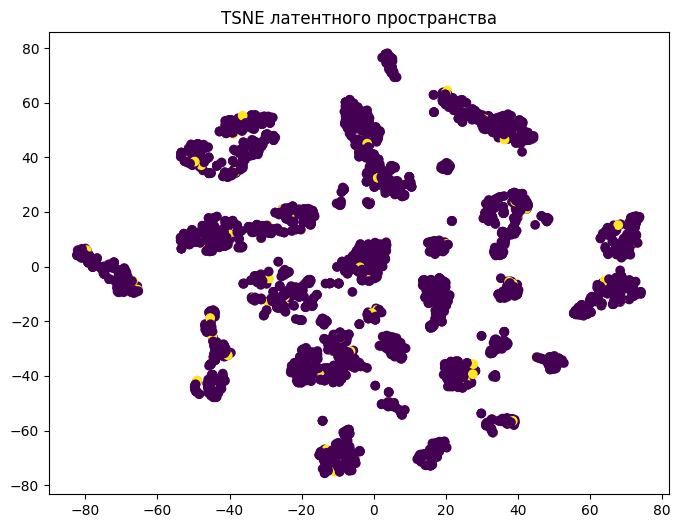

In [26]:
# Получаем латентные векторы тестовых изображений
latents = []
labels = []
for img, true in zip(test_ds.unbatch(), y_true):
    z = encoder.predict(tf.expand_dims(img, 0))
    latents.append(z[0])
    labels.append(true)

# TSNE
from sklearn.manifold import TSNE

z2 = TSNE(n_components=2).fit_transform(np.array(latents))

plt.figure(figsize=(8, 6))
plt.scatter(z2[:, 0], z2[:, 1], c=labels)
plt.title("TSNE латентного пространства")
plt.show()

In [28]:
!pip freeze > {PATH + "/requirements.txt"}